# Classification

Continuation of Segmentation process in which musical primitives found via Morphological Operations and Template Matching.

In [17]:
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Image loading, binarization, inversion and display
def load_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
def image_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
def image_bin_otsu(image_gs):
    ret,image_bin = cv2.threshold(image_gs, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    return image_bin
def invert(image):
    return 255-image
def display_image(image, color= False):
    plt.figure()
    if color:
        plt.imshow(image)
    else:
        plt.imshow(image, 'gray')
    plt.show()
    
# Image morphological operations
def dilate(image, kernel):
    return cv2.dilate(image, kernel, iterations=1)
def erode(image, kernel):
    return cv2.erode(image, kernel, iterations=1)
def open_image(image, kernel = None):
    if kernel is None:
        kernel = np.ones((1, 100))
    return dilate(erode(image, kernel), kernel)

# Horizontal projection
def horizontal_projection(image):
    hor_proj = []
    for i in range(len(image)):
        row_sum = 0
        for j in range(len(image[i])):
            row_sum += image[i][j] == 255
        hor_proj.append([255] * row_sum + [0] * (len(image[0]) - row_sum))

    return hor_proj

# Image crop
def crop_image(image, crop_start = None, crop_width = None):
    if crop_width is None:
        crop_width = len(image[0]) // 10
        
    if crop_start is None:
        end = 0
        for row in image:
            s = sum(row) / 255
            if s > end:
                end = s

        crop_start = end - crop_width
        
    cutoff = image[:]
    
    for i in range(len(cutoff)):
        cutoff[i] = cutoff[i][crop_start : crop_start + crop_width] 

    cutoff = np.array(cutoff, dtype = np.uint8)
    return cutoff

# Find Y coordinates of white pixels
def find_y(image):
    y = []
    for i in range(len(image)):
        for j in range(len(image[i])):
            if (image[i][j] == 255) and (i not in y):
                y.append(i)
    return sorted(y)

# Intersect two lists
def intersect_lists(first, second):
    ret_val = []
    for val in first:
        if val in second:
            ret_val += [val]
    return ret_val

# Group points and get distances
def label_y(y_list):
    labels = [[]]
    line_distances = []
    prev_y = None
    for y in y_list:
        if prev_y is not None:
            if y - prev_y > 1:
                labels.append([])
                line_distances += [y - prev_y]
        labels[-1] += [y]
        prev_y = y
    return labels, line_distances

# Find lines
def find_lines(image):
    first = find_y(crop_image(horizontal_projection(image)))
    second = find_y(open_image(image))
    
    
    lines, distances = label_y(intersect_lists(first, second))
    staff_spacings = [distances[i] for i in range(len(distances)) if (i+1) % 5 != 0 ]
    staff_spacing = sum(staff_spacings) * 1./len(staff_spacings)
    return lines, distances, staff_spacing

# Remove lines
def remove_lines(org_image, tolerance = 0, lines = None, topBotPixelRemoval = False, widthBasedRemoval = True):
    image = org_image.copy()
    
    if lines == None:
        lines, distances, staff_spacing = find_lines(org_image)
    
    if topBotPixelRemoval:
        for line in lines:
            top = line[0]
            bot = line[-1]
            for j in range(len(image[top])):
                remove = True
                is_line = False
                for row in image[top:bot+1]:
                    if row[j] == 255:
                        is_line = True
                        break
                if not is_line:
                    continue
                # check 2 pixels above and below
                diff = 2
                for row in image[top - diff : top]:
                    if row[j] == 255:
                        remove = False
                        break
                if remove:
                    for row in image[bot + 1: bot + diff + 1]:
                        if row[j] == 255:
                            remove = False
                            break
                if remove:
                    for row in image[top:bot+1]:
                        row[j] = 0
    
    if widthBasedRemoval:
        avg_thickness = lines[:]
        for i, line in enumerate(avg_thickness):
            avg_thickness[i] = len(line)
        avg_thickness = sum(avg_thickness) * 1./len(avg_thickness)

        for j in range(len(image[0])):
            white = False
            for i in range(len(image)):
                if image[i][j] == 255:
                    if not white:
                        start = i
                    white = True
                else:
                    if white:
                        thickness = i - start
                        if thickness <= (avg_thickness + tolerance):
                            for row in image[start : i]:
                                row[j] = 0
                    white = False
    return image

# Vertical lines recognition
def add_region(image, row, col, regions):
    coords = [(row, col)]
    idx = 0
    while (idx < len(coords)):
        row, col = coords[idx]
        for dr in range(-1,2):
            for dc in range(-1,2):
                r = row + dr
                c = col + dc
                if r >= 0 and c >= 0 and r < len(image) and c < len(image[r]):
                    if image[r][c] == 255 and ((r,c) not in coords):
                        for region in regions:
                            if (r,c) in region:
                                for coord in coords:
                                    region.append((r,c))
                                    return
                        coords += [(r,c)]
        idx += 1
    regions.append(coords)

def find_vertical_lines(image):
    # Find lines, distances
    lines, distances, staff_spacing = find_lines(image)

    # Find vertical objects
    img_open = open_image(remove_lines(image), np.ones((1.5 * staff_spacing, 1)))
    return img_open

def find_vertical_objects(image, image_vert_lines):
    # Label regions of interest
    regions = []
    for row in range(len(image_vert_lines)):
        for col in range(len(image_vert_lines[row])):
            if image_vert_lines[row][col] == 0:
                continue
            isFound = False
            for region in regions:
                if (row,col) in region:
                    isFound = True
                    break
            if isFound:
                continue
            add_region(img_wo_lines, row, col, regions)
    
    img_regions = image.copy()
    for row in range(len(img_regions)):
        for col in range(len(img_regions[row])):
            img_regions[row][col] = 0

    for region in regions:
        for row, col in region:
            img_regions[row, col] = 255
            
    return img_regions, regions

def split_image(image, regions):
    split_images = []
    for region in regions:
        minr = min([r for r,c in region])
        maxr = max([r for r,c in region])
        minc = min([c for r,c in region])
        maxc = max([c for r,c in region])
        sub_image = []
        for row in range(minr,maxr+1):
            sub_image.append([])
            for col in range(minc,maxc+1):
                sub_image[-1] += [image[row][col]]
        sub_image = np.array(sub_image)
        sub_image = np.uint8(sub_image)
        split_images.append(sub_image)
    return split_images

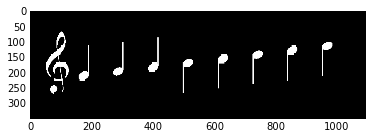

In [2]:
org_image = load_image("test_images/staff-with-notes.jpg")
img_gray = image_gray(org_image)
img_otsu = image_bin_otsu(img_gray)
inv_img = invert(img_otsu)
img_wo_lines = remove_lines(inv_img, 0)
display_image(img_wo_lines)

We find the vertical objects.

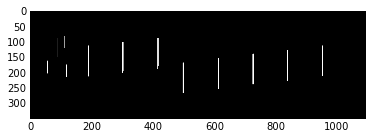

In [3]:
img_vert_lines = find_vertical_lines(inv_img)
display_image(img_vert_lines)

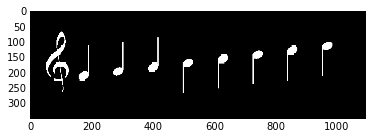

Number of recognized objects: 9


In [4]:
img_vert_objects, regions = find_vertical_objects(inv_img, img_vert_lines)
display_image(img_vert_objects)
print("Number of recognized objects: %s" % len(regions))

Now, template matching will be performed. Several templates will be used to find vertical objects. Only ones present in the current image are G-clef and filled note heads. We will focus on G-clef first.

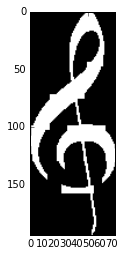

In [19]:
objects = split_image(img_vert_objects, regions)
display_image(objects[0])

A template for G-clef is searched through the <i>templates</i> folder.

In [22]:
from os import listdir
from os.path import isdir
g_clef_templates = []

vertFile = "clefs/g_clef"
split = vertFile.split('/')
for listedFile in listdir("templates"):
    if listedFile == split[0]:
        for innerFile in listdir("templates/%s" % listedFile):
            if len(split) == 1 or innerFile.startswith(split[1]):
                g_clef_templates += ["templates/%s/%s" % (listedFile, innerFile)]

print(g_clef_templates)

['templates/clefs/g_clef_01.jpg']


Next, we try to resize the template so it's size is equal to vertical objects bounding box.

------------- WORK IN PROGRESS -----------

In [ ]:
threshold = 0.7
correlations = {}
for template in templates:
    print("Template matching: %s" % template)
    max_correlation = 0
    template_name = template
    template = load_image(template)
    template = image_gray(template)
    template = image_bin_otsu(template)
    template = invert(template)
    height = len(template)
    width = len(template[0])
    correlation = np.zeros((len(img_wo_lines) - height, len(img_wo_lines[0]) - width))
    for row in range(len(correlation)):
        for col in range(len(correlation[row])):
            for dy in range(height):
                for dx in range(width):
                    correlation[row][col] += img_wo_lines[row + dy][col + dx] * template[dy][dx]
    correlation *= 1./(width * height)
    correlations[template_name] = correlation
    match_img = np.zeros((len(img_wo_lines), len(img_wo_lines[0])))
    for row in range(len(correlation)):
        for col in range(len(correlation[row])):
            if correlation[row][col] >= threshold:
                for dy in range(height):
                    for dx in range(width):
                        match_img[row + dy][col + dx] = img_wo_lines[row + dy][col + dx]
            if correlation[row][col] > max_correlation:
                max_correlation = correlation[row][col]
    match_img = np.uint8(match_img)
    display_image(match_img)
    print("max correlation: %s" % max_correlation)
            

In [ ]:
from os import listdir
from os.path import isdir

vertical_objects_files = [
    "clefs/g_clef",
    "lines/bar_line",
    "note_heads/filled"
]

templates = []

for listedFile in listdir("templates"):
    for vertFile in vertical_objects_files:
        split = vertFile.split('/')
        if listedFile == split[0]:
            for innerFile in listdir("templates/%s" % listedFile):
                if len(split) == 1 or innerFile.startswith(split[1]):
                    templates += ["templates/%s/%s" % (listedFile, innerFile)]


In [ ]:
threshold = 0.7
correlations = {}
for template in templates:
    print("Template matching: %s" % template)
    max_correlation = 0
    template_name = template
    template = load_image(template)
    template = image_gray(template)
    template = image_bin_otsu(template)
    template = invert(template)
    height = len(template)
    width = len(template[0])
    correlation = np.zeros((len(img_wo_lines) - height, len(img_wo_lines[0]) - width))
    for row in range(len(correlation)):
        for col in range(len(correlation[row])):
            for dy in range(height):
                for dx in range(width):
                    correlation[row][col] += img_wo_lines[row + dy][col + dx] * template[dy][dx]
    correlation *= 1./(width * height)
    correlations[template_name] = correlation
    match_img = np.zeros((len(img_wo_lines), len(img_wo_lines[0])))
    for row in range(len(correlation)):
        for col in range(len(correlation[row])):
            if correlation[row][col] >= threshold:
                for dy in range(height):
                    for dx in range(width):
                        match_img[row + dy][col + dx] = img_wo_lines[row + dy][col + dx]
            if correlation[row][col] > max_correlation:
                max_correlation = correlation[row][col]
    match_img = np.uint8(match_img)
    display_image(match_img)
    print("max correlation: %s" % max_correlation)
            

Next, a morphological opening of the image will be performed with a disk shaped kernel, whose size is half of the staff spacing. This way, filled note heads can be found.

In [ ]:
def find_filled_note_heads(image):
    # Find lines, distances
    lines, distances, staff_spacing = find_lines(image)
    n = int(staff_spacing / 4.)
    y,x = np.ogrid[-n : n +1, -n : n+1]
    mask = x*x+y*y <= n*n

    kernel = np.zeros((len(mask), len(mask)))
    kernel[mask] = 1
    kernel = np.uint8(kernel)
    return open_image(remove_lines(image), kernel)

img_filled_heads = find_filled_note_heads(inv_img)
display_image(img_filled_heads)

Merge the two images.

In [ ]:
img_mrg = img_filled_heads + img_vert_lines
display_image(img_mrg)

Remove the vertical lines that belong to the bar line

In [ ]:
org_image = load_image("test_images/eighth_notes.jpg")
img_gray = image_gray(org_image)
img_otsu = image_bin_otsu(img_gray)
inv_img = invert(img_otsu)
img_wo_lines = remove_lines(inv_img, 0)
display_image(img_wo_lines)
img_vert_lines, regions = find_vertical_lines(inv_img)
display_image(img_vert_lines)
img_filled_heads = find_filled_note_heads(inv_img)
display_image(img_filled_heads)
img_mrg = img_filled_heads + img_vert_lines
display_image(img_mrg)